In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [3]:
df = data.copy()

In [4]:
df.shape

(2443651, 9)

In [5]:
df.columns.nunique

<bound method IndexOpsMixin.nunique of Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')>

In [6]:
df.sample(10)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
747254,806083,B078M73SCK,2 Pack Thick Oval Dented Electric Guitar Jack ...,4.2,49,6.88,False,0,Guitars & Gear
755686,815225,B0BQLR5XMX,QRTTLY 48V 14S 45A - Battery BMS PCB With Bala...,0.0,0,22.93,False,0,Sports & Outdoors
902141,981638,B08BRZ6JDS,Callaway Golf Mens Golf 1/2 Zip Block Jacket -...,5.0,1,53.49,False,0,Sports & Outdoors
1593508,1794574,B07XBMRKK7,Personalised Football Shirt Number Cushion Han...,4.8,20,27.95,False,0,Handmade Home Décor
134639,146103,B0C5XPTSYR,Women's T-Shirt Top Women's T-Shirt Blouses & ...,0.0,0,10.95,False,0,Sports & Outdoors
57784,62427,B08T1HJTLX,WHYSP 61 PBT Purple Keycaps for 60 Percent Key...,4.4,407,32.82,False,0,PC Gaming Accessories
1152905,1274309,B007136EDG,Skullcandy Ink'd 2.0 In-Ear Headphones with In...,4.2,32073,16.00,False,0,Headphones & Earphones
1904081,2135651,B07Z6BLSL2,Rutland County Garden Furniture Cottesmore 6ft...,4.7,12,329.99,False,0,Garden Storage & Housing
2261200,2610004,B0CF4LVK7C,Leapiture Bluetooth Speaker W2 Wireless Portab...,0.0,0,15.09,False,0,Hi-Fi Speakers
661066,710350,B0C3LY2YLC,JMEOWIO 3D Embossed Spring Flower Nail Art Sti...,5.0,1,6.89,False,0,Manicure & Pedicure Products


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.


1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


In [7]:
cross_tab = pd.crosstab(df['category'], df['isBestSeller'], margins=True)

In [8]:
cross_tab

isBestSeller,False,True,All
category,,,
3D Printers,247,1,248
3D Printing & Scanning,4065,2,4067
Abrasive & Finishing Products,245,5,250
Action Cameras,1696,1,1697
Adapters,251,3,254
...,...,...,...
Window Treatments,234,5,239
Women,17559,213,17772
Women's Sports & Outdoor Shoes,1939,20,1959


In [9]:
cross_tab.dtypes

isBestSeller
False    int64
True     int64
All      int64
dtype: object

In [10]:
cross_tab_prop = cross_tab.copy()
cross_tab_prop['Proportion'] = cross_tab[1] / cross_tab['All']
cross_tab_prop

isBestSeller,False,True,All,Proportion
category,,,,
3D Printers,247,1,248,0.004032
3D Printing & Scanning,4065,2,4067,0.000492
Abrasive & Finishing Products,245,5,250,0.020000
Action Cameras,1696,1,1697,0.000589
Adapters,251,3,254,0.011811
...,...,...,...,...
Window Treatments,234,5,239,0.020921
Women,17559,213,17772,0.011985
Women's Sports & Outdoor Shoes,1939,20,1959,0.010209


In [11]:
cross_tab_prop_sorted = cross_tab_prop.sort_values(by='Proportion', ascending= False)
cross_tab_prop_sorted

isBestSeller,False,True,All,Proportion
category,,,,
Grocery,9008,556,9564,0.058135
Smart Home Security & Lighting,98,6,104,0.057692
Health & Personal Care,9017,552,9569,0.057686
Mobile Phone Accessories,248,11,259,0.042471
Power & Hand Tools,8353,306,8659,0.035339
...,...,...,...,...
Snowboard Boots,1449,0,1449,0.000000
Internal TV Tuner & Video Capture Cards,253,0,253,0.000000
Boxes & Organisers,911,0,911,0.000000


In [12]:
bestsellercategories = [cross_tab_prop_sorted.index[0],cross_tab_prop_sorted.index[1],cross_tab_prop_sorted.index[2],cross_tab_prop_sorted.index[3],cross_tab_prop_sorted.index[4]]

print(f'Easiest categories to find Best sellers: {bestsellercategories}')


Easiest categories to find Best sellers: ['Grocery', 'Smart Home Security & Lighting', 'Health & Personal Care', 'Mobile Phone Accessories', 'Power & Hand Tools']



2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.


In [13]:
cross_tab =cross_tab.drop("All", axis=0)

In [14]:
_, p_value, _, _ = chi2_contingency(cross_tab)
p_value
num_sci = p_value
print(f'{num_sci:.2000f}')

0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

The null hypothesis of the Chi-square test is that the two categorical variables are independent. Given Null value ( p )-value, we reject the null hypothesis.

In [15]:
association(cross_tab)

0.061141471988028204

The value 0.061141471988028204 likely represents the strength of association between the categories of books and their status as bestsellers, with a Cramer's V statistic of approximately 0.061. This suggests a relatively weak association between these variables in the context of the analysis.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [16]:
cross_tab2 = cross_tab.drop(columns=['All'])
cross_tab2.reset_index(inplace=True)
cross_tab2

isBestSeller,category,False,True
0,3D Printers,247,1
1,3D Printing & Scanning,4065,2
2,Abrasive & Finishing Products,245,5
3,Action Cameras,1696,1
4,Adapters,251,3
...,...,...,...
291,Wind Instruments,243,7
292,Window Treatments,234,5
293,Women,17559,213
294,Women's Sports & Outdoor Shoes,1939,20


<Figure size 2000x1200 with 0 Axes>

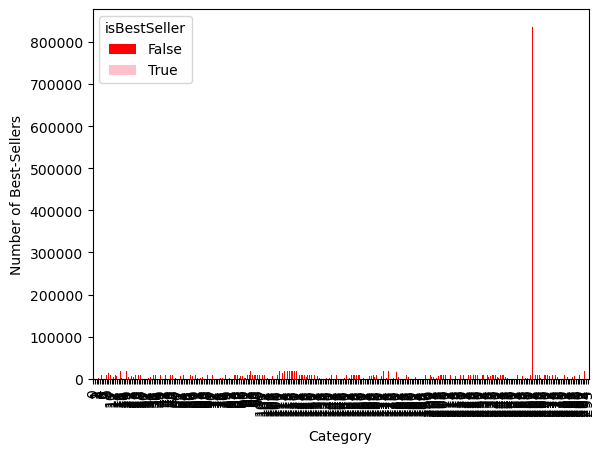

In [17]:
plt.figure(figsize = (20,12))
cross_tab2.plot(kind ='bar', stacked = "Proportion", color=["red","pink"])
plt.xlabel("Category", labelpad=10, loc='center')
plt.ylabel("Number of Best-Sellers")
plt.xticks(rotation=90)
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.



0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*



In [18]:
df["price"].describe().round(2)

count    2443651.00
mean          89.24
std          345.61
min            0.00
25%            9.99
50%           19.09
75%           45.99
max       100000.00
Name: price, dtype: float64

In [19]:
Q1 = np.percentile(df["price"],25)
Q3 = np.percentile(df["price"],75)
IQR = Q3-Q1

In [20]:
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

In [21]:
df_outliers= df[(df["price"]< lower_bound) | (df["price"]> upper_bound)]

In [22]:
df2 = df[(df["price"]>= lower_bound) & (df["price"]<=upper_bound)]

In [23]:
df2

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.



In [24]:
top_categories = df2['category'].value_counts().head(20).index
df2filter = df2[df2['category'].isin(top_categories)]

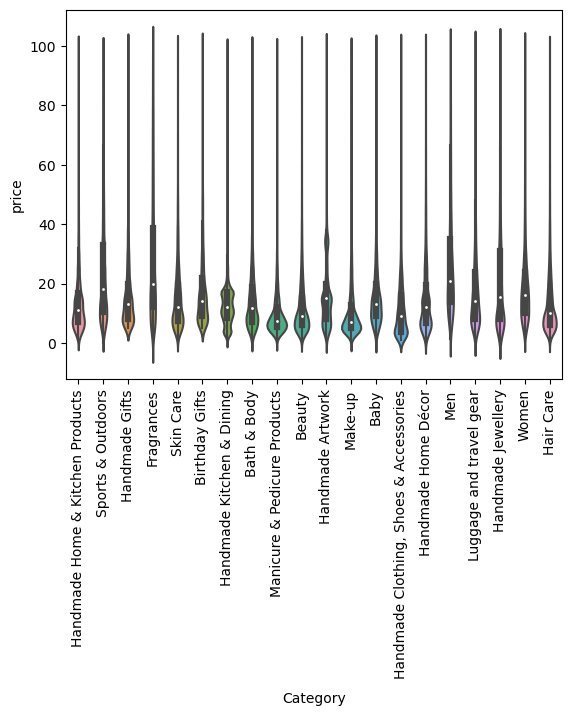

In [25]:
sns.violinplot(data=df2filter, x="category", y="price")
plt.xticks(rotation=90)
plt.xlabel("Category", labelpad=10, loc='center')
plt.show()

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.



In [26]:
df_avg_prices =  df2.groupby("category")["price"].mean()
top10 = df_avg_prices.nlargest(10)

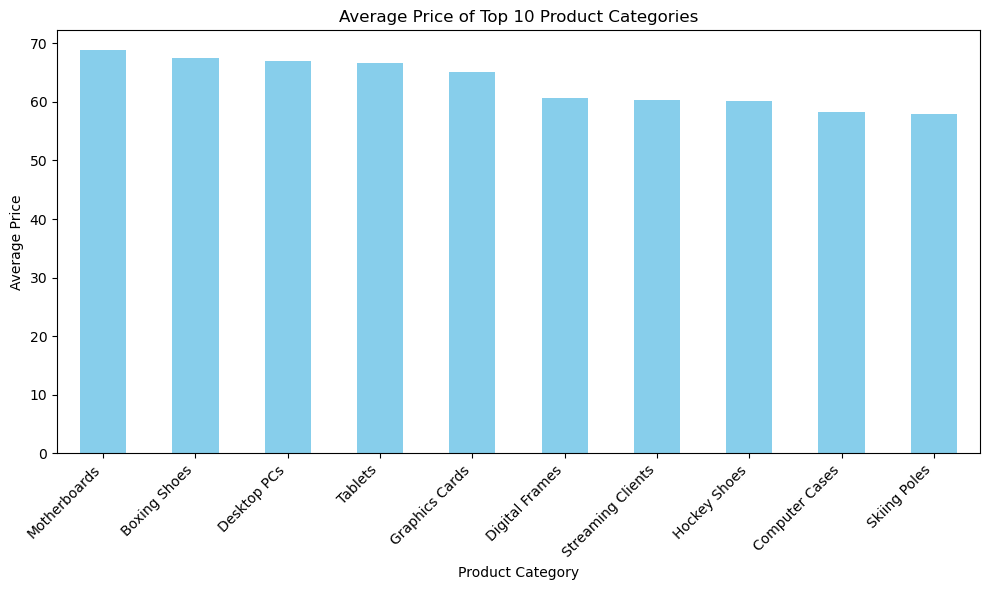

In [27]:
plt.figure(figsize=(10, 6))
top10.plot(kind='bar', color='skyblue')
plt.title('Average Price of Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [28]:
highest_avg_price_category = df_avg_prices.idxmax()
highest_avg_price_product = df_avg_prices.max()
print(f"The product category with the highest average price is {highest_avg_price_category} with an average price of {highest_avg_price_product}")

The product category with the highest average price is Motherboards with an average price of 68.77243243243242


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.



1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 